<a href="https://colab.research.google.com/github/vipin-jangra/2048-JAVA/blob/master/D1_CNN5_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import keras
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
def preprocess_image(image_path):
    # Read grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize image to (224, 224)
    image = cv2.resize(image, (224, 224))
    # Convert grayscale to RGB by stacking the single channel
    image_rgb = np.stack((image,) * 3, axis=-1)
    return image_rgb

In [4]:
from google.colab import drive

drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/Dataset/Dataset2/crop_part1.zip'

Streaming output truncated to the last 5000 lines.
  inflating: crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104204327523.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170105164106036.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170105172720493.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170108224608753.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170109140259136.jpg.

In [5]:
# Define age ranges
age_ranges = [(1, 2), (3, 9), (10, 20), (21, 27), (28, 45), (46, 65), (66, 116)]

# Function to map age to range index
def age_to_range(age, age_ranges):
    for idx, (start, end) in enumerate(age_ranges):
        if start <= age <= end:
            return idx
    return None

In [6]:
def preprocess_labels(labels, num_classes):
    # One-hot encode labels
    labels = to_categorical(labels, num_classes=num_classes)
    return labels

In [7]:
# Load and preprocess the dataset
image_dir = '/content/crop_part1'
images=[]
image_paths = []
age_labels = []
age_groups = []
target_size = (224, 224)

for filename in os.listdir(image_dir):
  if filename.endswith(".jpg"):
    age = int(filename.split('_')[0])
    range_index = age_to_range(age, age_ranges)
    age_labels.append(range_index)

    image_path = os.path.join(image_dir, filename)
    image = preprocess_image(image_path)
    images.append(image)
    image_paths.append(image_path)

images = np.array(images)
age_groups = age_labels
age_labels = preprocess_labels(age_labels, len(age_ranges))

In [8]:
# Print shapes
print(f"Images shape: {images.shape}")
print(f"Labels shape: {age_labels.shape}")

Images shape: (9780, 224, 224, 3)
Labels shape: (9780, 7)


In [9]:
def age_group_to_interval(group_index):
    if group_index < 0 or group_index >= len(age_ranges):
        return "Unknown"

    start, end = age_ranges[group_index]
    return f"{start}-{end}"

In [10]:
import pandas as pd
df = pd.DataFrame()
age_intervals = [age_group_to_interval(age) for age in age_groups]
df['images_path'],df['age'] = image_paths,age_intervals
df.head(10)

,images_path,age
0,/content/crop_part1/32_0_4_20170103235323876.j...,28-45
1,/content/crop_part1/3_1_2_20161219151433163.jp...,3-9
2,/content/crop_part1/30_1_0_20170103183908075.j...,28-45
3,/content/crop_part1/47_1_0_20170104184702870.j...,46-65
4,/content/crop_part1/53_0_0_20170104212411036.j...,46-65
5,/content/crop_part1/20_0_0_20170104230042553.j...,10-20
6,/content/crop_part1/47_0_0_20170104211830788.j...,46-65
7,/content/crop_part1/37_1_0_20170109134546708.j...,28-45
8,/content/crop_part1/9_0_2_20170110215518068.jp...,3-9
9,/content/crop_part1/2_1_4_20170103210839634.jp...,1-2


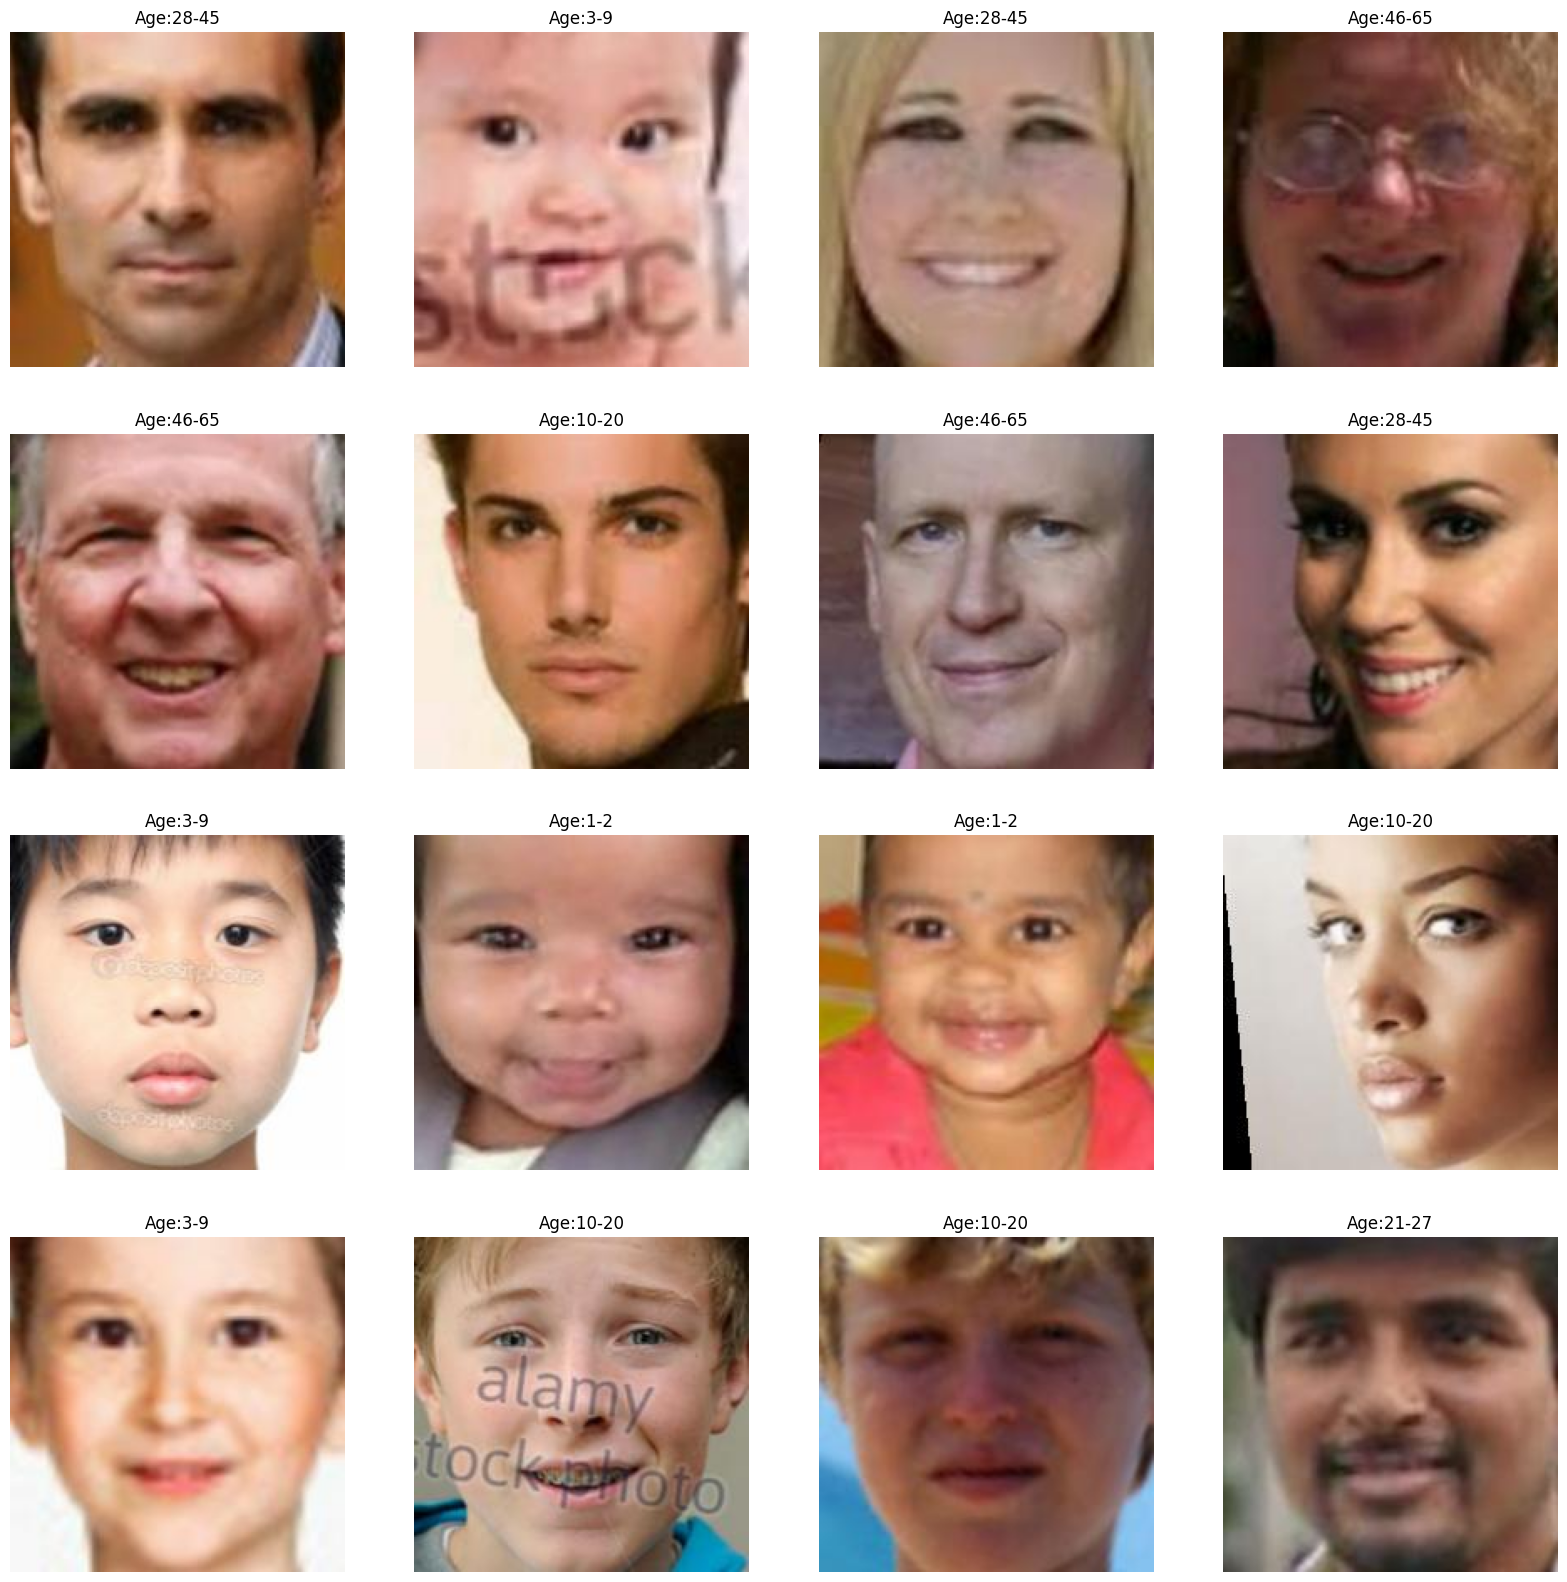

In [11]:
plt.figure(figsize=(20,20))
samples = df.iloc[0:16]

for index,sample,age in samples.itertuples():
  plt.subplot(4,4,index+1)
  img = load_img(sample)
  img = np.array(img)
  plt.axis('off')
  plt.title(f'Age:{age}')
  plt.imshow(img)

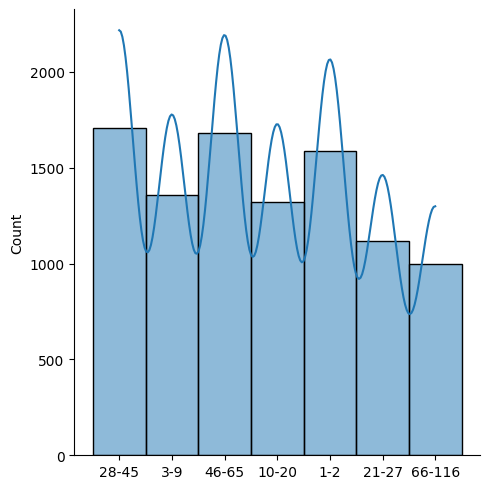

In [12]:
#age distribution
sns.displot(data=age_intervals,kde=True)

In [13]:
train_images, test_images, train_age_groups, test_age_groups = train_test_split(images, age_labels, test_size=0.2, random_state=42)


In [14]:
bnmomemtum=0.9
def fire(x, squeeze, expand):
  y  = keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
  y = keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
  y1 = keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
  y1 = keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
  y3 = keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
  y3 = keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
  return keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

x = keras.layers.Input(shape=[224, 224, 3]) # input is 192x192 pixels RGB

y = keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
y = fire_module(24, 48)(y)
y = keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(64, 128)(y)
y = keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = keras.layers.GlobalAveragePooling2D()(y)
y = keras.layers.Dense(len(age_ranges), activation='softmax')(y)

model = keras.Model(x, y)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dataset/Dataset2/model-weights/CROP_D1_CNN3_A3.h5',  # Filepath to save the best model
    monitor='val_accuracy',  # Metric to monitor
    verbose=1,
    save_best_only=True,  # Only save the best model
    mode='max'  # Mode to determine best (maximizing validation accuracy)
)


In [16]:
model.fit(train_images, train_age_groups, validation_split=0.2, epochs=60, batch_size=32, callbacks=[early_stopping, model_checkpoint], shuffle=False)


Epoch 1/60
196/196 [==============================] - ETA: 0s - loss: 1.7293 - accuracy: 0.3170
Epoch 1: val_accuracy improved from -inf to 0.30415, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/CROP_D1_CNN3_A3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


196/196 [==============================] - 49s 162ms/step - loss: 1.7293 - accuracy: 0.3170 - val_loss: 1.7332 - val_accuracy: 0.3042
Epoch 2/60
196/196 [==============================] - ETA: 0s - loss: 1.5792 - accuracy: 0.3847
Epoch 2: val_accuracy improved from 0.30415 to 0.41214, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/CROP_D1_CNN3_A3.h5
196/196 [==============================] - 27s 140ms/step - loss: 1.5792 - accuracy: 0.3847 - val_loss: 1.5442 - val_accuracy: 0.4121
Epoch 3/60
196/196 [==============================] - ETA: 0s - loss: 1.4935 - accuracy: 0.4076
Epoch 3: val_accuracy improved from 0.41214 to 0.42236, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/CROP_D1_CNN3_A3.h5
196/196 [==============================] - 27s 140ms/step - loss: 1.4935 - accuracy: 0.4076 - val_loss: 1.4737 - val_accuracy: 0.4224
Epoch 4/60
196/196 [==============================] - ETA: 0s - loss: 1.4270 - accuracy: 0.4311
Epoch 4: val_accurac

In [17]:
# Load the best model
model.load_weights('/content/drive/MyDrive/Dataset/Dataset2/model-weights/CROP_D1_CNN3_A3.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_age_groups)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


62/62 [==============================] - 3s 50ms/step - loss: 1.1957 - accuracy: 0.5148
Test Accuracy: 51.48%


In [18]:

predictions = model.predict(test_images)

# Convert predictions to class labels if needed
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_age_groups, axis=1)

62/62 [==============================] - 3s 44ms/step


In [19]:
# Example metrics calculation
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80       319
           1       0.54      0.39      0.45       275
           2       0.36      0.47      0.41       236
           3       0.42      0.31      0.35       237
           4       0.46      0.67      0.54       372
           5       0.46      0.38      0.41       324
           6       0.72      0.38      0.49       193

    accuracy                           0.51      1956
   macro avg       0.53      0.49      0.50      1956
weighted avg       0.53      0.51      0.51      1956



In [20]:
# Calculate classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.51
Precision: 0.53
Recall: 0.51
F1-score: 0.51


In [21]:
# Calculate accuracy for each class
class_accuracies = {}
for idx, (start, end) in enumerate(age_ranges):
    # Filter predictions and true labels for the current class
    mask = (true_classes == idx)
    accuracy = accuracy_score(true_classes[mask], predicted_classes[mask])
    class_accuracies[f'{start}-{end}'] = accuracy

In [22]:
# Print accuracy for each class
for age_range, accuracy in class_accuracies.items():
    print(f'Accuracy for age range {age_range}: {accuracy:.2f}')

Accuracy for age range 1-2: 0.85
Accuracy for age range 3-9: 0.39
Accuracy for age range 10-20: 0.47
Accuracy for age range 21-27: 0.31
Accuracy for age range 28-45: 0.67
Accuracy for age range 46-65: 0.38
Accuracy for age range 66-116: 0.38


In [23]:
from sklearn.metrics import confusion_matrix
# Detailed classification report
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=[f'{start}-{end}' for start, end in age_ranges]))

# Confusion Matrix
print('\nConfusion Matrix:')
print(confusion_matrix(true_classes, predicted_classes))


Classification Report:
              precision    recall  f1-score   support

         1-2       0.76      0.85      0.80       319
         3-9       0.54      0.39      0.45       275
       10-20       0.36      0.47      0.41       236
       21-27       0.42      0.31      0.35       237
       28-45       0.46      0.67      0.54       372
       46-65       0.46      0.38      0.41       324
      66-116       0.72      0.38      0.49       193

    accuracy                           0.51      1956
   macro avg       0.53      0.49      0.50      1956
weighted avg       0.53      0.51      0.51      1956


Confusion Matrix:
[[270  36   4   3   4   1   1]
 [ 62 107  65  13  23   4   1]
 [  7  32 111  33  50   3   0]
 [  6   5  42  73 101  10   0]
 [  2   3  29  41 250  46   1]
 [  6  11  41  12 105 123  26]
 [  3   6  15   0  13  83  73]]
